In [1]:
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import product
from collections import Counter
from datasets import load_dataset
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

In [2]:
def metric_calculation(pred, gt):    
    acc=accuracy_score(gt, pred)
    f1=f1_score(gt, pred, average='macro')
    confusion=confusion_matrix(gt, pred)
    fpr=confusion[0,1]/len(gt) ## predict to be 1; actual 0
    fnr=confusion[1,0]/len(gt) ## predict to be 0; actual 1
    return acc, f1, fpr, fnr
    
def post_processing(pred):
    new_pred=[]
    for i in pred:
        i=i.lower()
        if 'response' in i:
            try: new_pred.append(i.split('response')[1].split()[1].replace('</s>', ''))
            except: new_pred.append(2)
        elif 'output' in i:
            try: new_pred.append(i.split('output')[1].split()[1].replace('</s>', ''))
            except: new_pred.append(2)
        else:
            try: new_pred.append(i.split()[0].replace('</s>', ''))
            except:new_pred.append(2)
    new_pred = np.array([int(float(i)) if i in ['0', '0.0', '1', '1.0'] else 2 for i in new_pred])
    return new_pred

## no values

In [3]:
ds = load_dataset("beanham/spatial_join_dataset")
test=ds['test']
gt=np.array(test['label'])
configs = [
    'zero_shot_no_heur',    
    'zero_shot_with_heur_hint_angle',
    'zero_shot_with_heur_hint_distance',
    'zero_shot_with_heur_hint_area',
    'zero_shot_with_heur_hint_angle_distance',
    'zero_shot_with_heur_hint_angle_area',
    'zero_shot_with_heur_hint_distance_area',
    'zero_shot_with_heur_hint_all',    
    'few_shot_no_heur',    
    'few_shot_with_heur_hint_angle',
    'few_shot_with_heur_hint_distance',
    'few_shot_with_heur_hint_area',
    'few_shot_with_heur_hint_angle_distance',
    'few_shot_with_heur_hint_angle_area',
    'few_shot_with_heur_hint_distance_area',
    'few_shot_with_heur_hint_all'
]
new_names={
    'zero_shot_no_heur':'(plain)', 
    'zero_shot_with_heur_hint_angle': '(p)',
    'zero_shot_with_heur_hint_distance': '(c)',
    'zero_shot_with_heur_hint_area': '(o)',
    'zero_shot_with_heur_hint_angle_distance': '(p,c)',
    'zero_shot_with_heur_hint_angle_area': '(p,o)',
    'zero_shot_with_heur_hint_distance_area': '(c,o)',
    'zero_shot_with_heur_hint_all': '(p,c,o)',
    'few_shot_no_heur':'(plain)', 
    'few_shot_with_heur_hint_angle': '(p)',
    'few_shot_with_heur_hint_distance': '(c)',
    'few_shot_with_heur_hint_area': '(o)',
    'few_shot_with_heur_hint_angle_distance': '(p,c)',
    'few_shot_with_heur_hint_angle_area': '(p,o)',
    'few_shot_with_heur_hint_distance_area': '(c,o)',
    'few_shot_with_heur_hint_all': '(p,c,o)',
}
## evaluate on a subset
np.random.seed(100)
index=np.random.randint(0, 3069, 1000)

In [77]:
results=[]
models=['llama3', 'mistral', '4o_mini', 'qwen_plus', '4o']
for model in models:
    print(f'Model: {model}...')
    for config in configs:
        pred=np.load(f'base/{model}/{model}_{config}.npy')
        pred=post_processing(pred)        
        if len(pred)==1000:
            metrics=metric_calculation(pred, gt)
        else:
            metrics=metric_calculation(pred[index], gt)
        if 'zero_shot' in config:
            prompting='zero shot'
        else:
            prompting='few shot'
        results.append([new_names[config], prompting, model, metrics[0], metrics[1]])
results=pd.DataFrame(results, columns=['heuristics', 'prompting', 'model', 'acc', 'f1'])

Model: llama3...
Model: mistral...
Model: 4o_mini...
Model: qwen_plus...
Model: 4o...


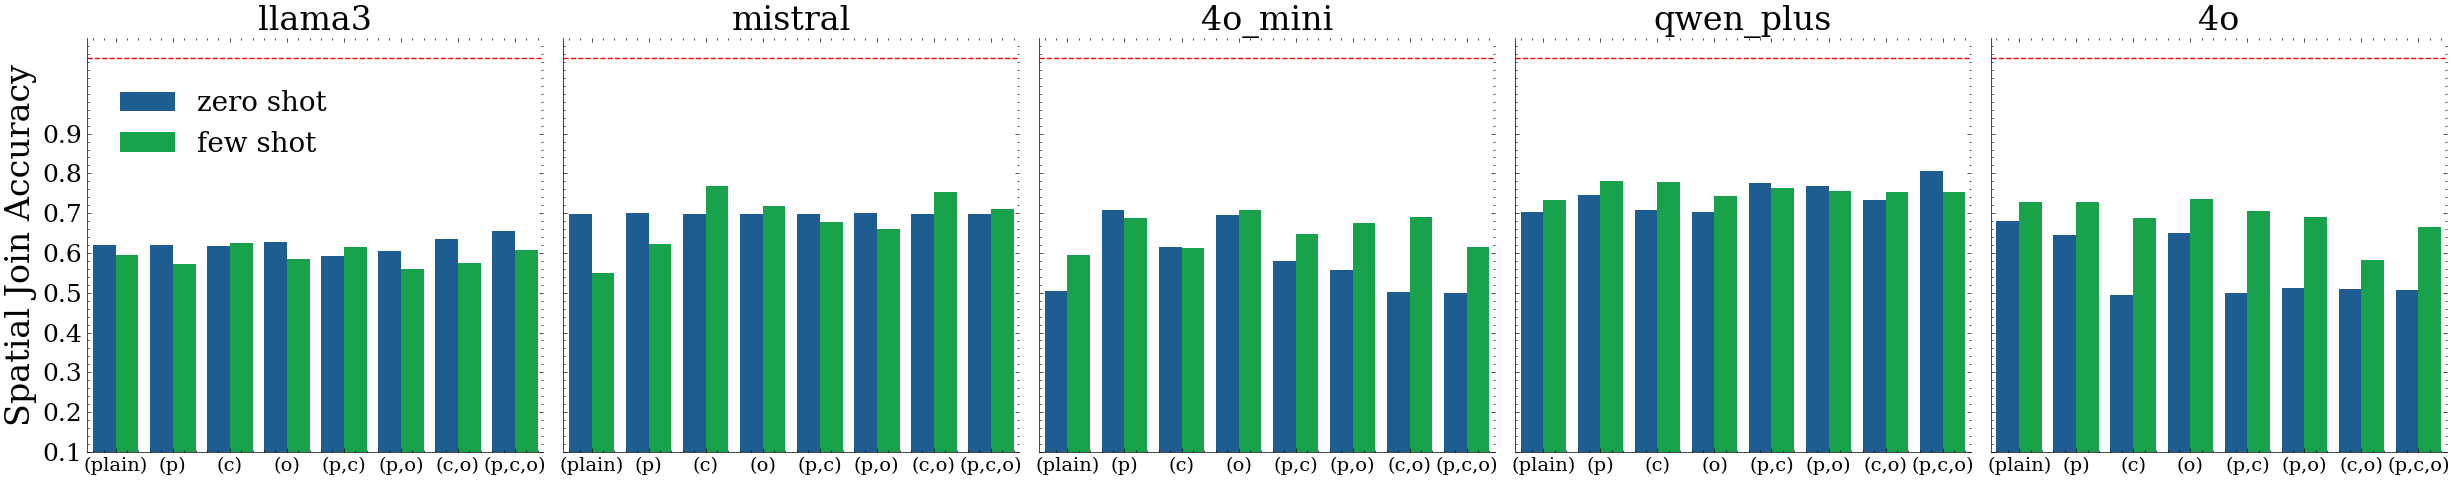

In [102]:
plt.style.use('science')
plt.rc('text', usetex=False)
plot=sns.catplot(results, kind="bar",x="heuristics", y="acc", hue="prompting", col="model")
plot.set_xlabels("")
plot.set_ylabels("Spatial Join Accuracy", fontsize=24)
plot.set_xticklabels(fontsize=14)
plot.set_yticklabels([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],fontsize=18)
plot.set_titles(col_template="{col_name}", size=24)
plot.refline(y=0.990, color='red', label='best_heuristic')
plot.legend.set_title("")
sns.move_legend(plot, "upper left", bbox_to_anchor=(.04, .85), fontsize=20)
plt.savefig('../../visualizations/join_task_no_heuristic_values.png', bbox_inches='tight',pad_inches=0, dpi=600)
pass